In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# I. Time-Series Forecasting

In [2]:
# Create a time-series dataset
np.random.seed(42)
date_range = pd.date_range(start='2020-01-01', end='2023-12-31', freq='M')
sales_data = np.random.randint(2000, 5000, size=len(date_range))

In [3]:
time_series_df = pd.DataFrame({
    'Date': date_range,
    'Sales': sales_data
})

# Set the 'Date' column as the index
time_series_df.set_index('Date', inplace=True)
time_series_df.head()

,Sales
Date,
2020-01-31,2860
2020-02-29,3294
2020-03-31,3130
2020-04-30,3095
2020-05-31,3638


In [4]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Apply Holt-Winters Exponential Smoothing
hw_model = ExponentialSmoothing(
    time_series_df['Sales'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

C:\Users\engrd\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


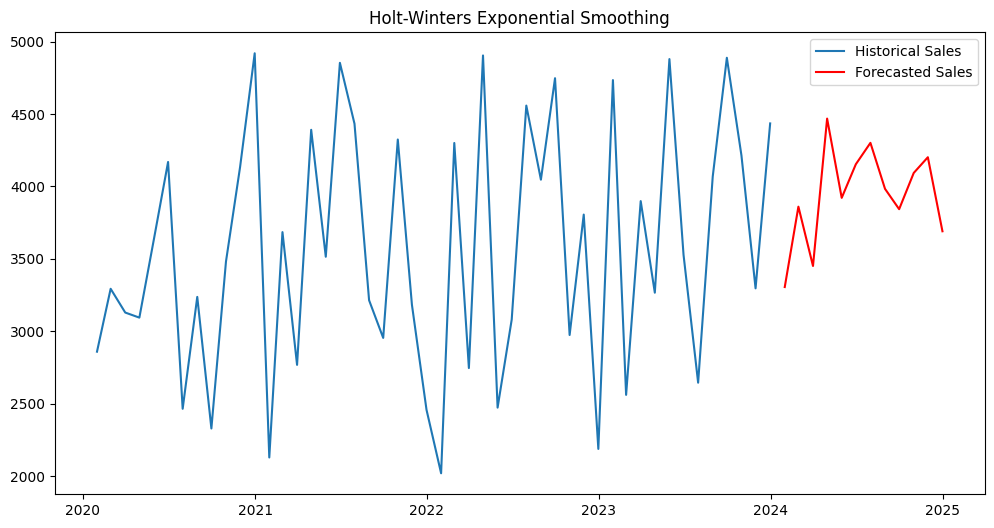

In [5]:
# Forecast future values
forecast_hw = hw_model.forecast(steps=12)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(time_series_df['Sales'], label='Historical Sales')
plt.plot(forecast_hw, label='Forecasted Sales', color='red')
plt.title('Holt-Winters Exponential Smoothing')
plt.legend()
plt.show()

In [6]:
from sklearn.linear_model import LinearRegression

# Create a time index for linear regression
time_index = np.arange(len(time_series_df)).reshape(-1, 1)

# Fit linear regression model
lr_model = LinearRegression().fit(time_index, time_series_df['Sales'])

In [7]:
# Make predictions
sales_trend = lr_model.predict(time_index)

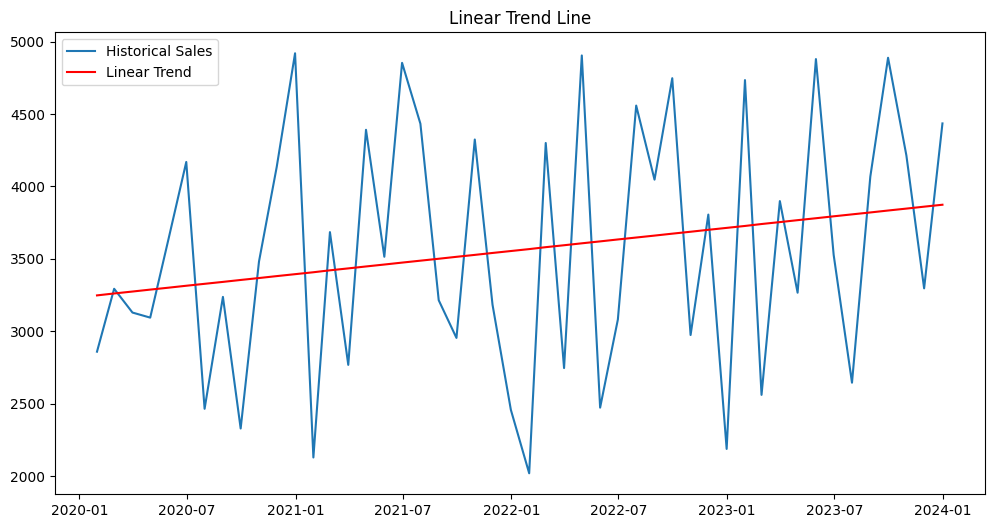

In [8]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(time_series_df['Sales'], label='Historical Sales')
plt.plot(time_series_df.index, sales_trend, label='Linear Trend', color='red')
plt.title('Linear Trend Line')
plt.legend()
plt.show()

<Figure size 1200x1000 with 0 Axes>

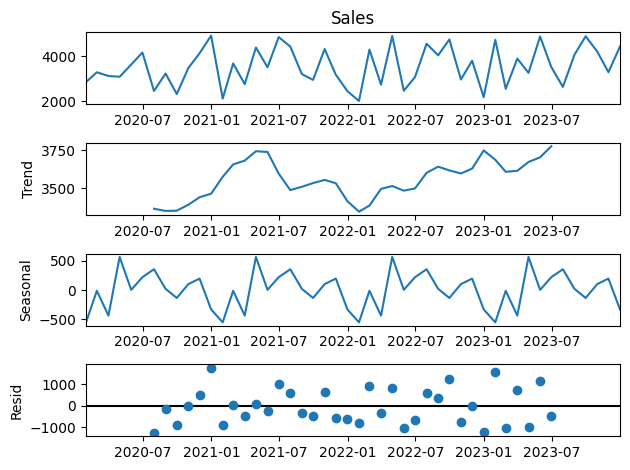

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(time_series_df['Sales'], model='additive', period=12)

# Plot the decomposition
plt.figure(figsize=(12, 10))
decomposition.plot()
plt.show()

# II. Transportation Model

### Supply: List of supply values for each source.
### Demand: List of demand values for each destination.
### Cost Matrix: Matrix representing transportation costs from each source to each destination.

In [10]:
import numpy as np

# Define supply, demand, and cost matrix
supply = [14, 19, 13]
demand = [12, 12, 12, 12]
cost = np.array([[500, 750, 300, 450],
                 [650, 800, 400, 600],
                 [400, 700, 500, 550]])

## a. Northwest Corner Method

In [11]:
def northwest_corner_method(supply, demand, cost):
    m, n = len(supply), len(demand)
    allocation = np.zeros((m, n), dtype=int)
    
    i, j = 0, 0
    while i < m and j < n:
        allocation[i, j] = min(supply[i], demand[j])
        supply[i] -= allocation[i, j]
        demand[j] -= allocation[i, j]
        if supply[i] == 0:
            i += 1
        else:
            j += 1
    return allocation

def compute_total_cost(allocation, cost):
    return np.sum(allocation * cost)

def check_oversupply_overdemand(supply, demand):
    total_supply = sum(supply)
    total_demand = sum(demand)
    if total_supply > total_demand:
        print(f"Oversupply: {total_supply - total_demand}")
    elif total_demand > total_supply:
        print(f"Overdemand: {total_demand - total_supply}")
    else:
        print("No oversupply or overdemand")

In [12]:
# Check for oversupply or overdemand
check_oversupply_overdemand(supply, demand)

Overdemand: 2


In [13]:
# Perform the Northwest Corner Method
allocation_nw = northwest_corner_method(supply.copy(), demand.copy(), cost)
print("Northwest Corner Allocation:\n", allocation_nw)

Northwest Corner Allocation:
 [[12  2  0  0]
 [ 0 10  9  0]
 [ 0  0  3 10]]


In [14]:
# Compute the total cost for the Northwest Corner Method
total_cost_nw = compute_total_cost(allocation_nw, cost)
print("Total Cost using Northwest Corner Method:", total_cost_nw)

Total Cost using Northwest Corner Method: 26100


## b. Minimal Cell Cost Method

In [15]:
def least_cost_method(supply, demand, cost):
    m, n = len(supply), len(demand)
    allocation = np.zeros((m, n), dtype=int)
    
    cost_copy = cost.copy()
    while np.any(supply) and np.any(demand):
        # Find the cell with the minimum cost
        min_cost_index = np.unravel_index(np.argmin(cost_copy, axis=None), cost_copy.shape)
        i, j = min_cost_index
        
        # Allocate as much as possible to the cell with the minimum cost
        allocation[i, j] = min(supply[i], demand[j])
        supply[i] -= allocation[i, j]
        demand[j] -= allocation[i, j]
        
        # Set the cost of the used cell to a large number
        large_number = 1e6
        if supply[i] == 0:
            cost_copy[i, :] = large_number
        if demand[j] == 0:
            cost_copy[:, j] = large_number
    
    return allocation

# Perform the Least Cost Method
allocation_lc = least_cost_method(supply.copy(), demand.copy(), cost)
print("Least Cost Allocation:\n", allocation_lc)

# Compute the total cost
def compute_total_cost(allocation, cost):
    return np.sum(allocation * cost)

Least Cost Allocation:
 [[ 0  0 12  2]
 [ 0 10  0  9]
 [12  0  0  1]]


In [16]:
# Compute the total cost for Least Cost Method
total_cost_lc = compute_total_cost(allocation_lc, cost)
print("Total Cost using Least Cost Method:", total_cost_lc)

Total Cost using Least Cost Method: 23250


## c. Linear Programming with Simplex Method for Optimal Solution

In [17]:
import numpy as np
from scipy.optimize import linprog

# Check if total supply matches total demand
total_supply = sum(supply)
total_demand = sum(demand)

if total_supply != total_demand:
    print("Total supply must equal total demand for a balanced transportation problem.")
    if total_supply > total_demand:
        print(f"Oversupply: {total_supply - total_demand}")
        demand.append(total_supply - total_demand)
        dummy_cost = [0] * len(supply)  # Cost of transporting to dummy destination is zero
        cost = np.hstack((cost, np.array(dummy_cost).reshape(-1, 1)))
    else:
        print(f"Overdemand: {total_demand - total_supply}")
        supply.append(total_demand - total_supply)
        dummy_cost = [0] * len(demand)  # Cost of transporting from dummy source is zero
        cost = np.vstack((cost, np.array(dummy_cost).reshape(1, -1)))

# Convert cost matrix to a vector
c = cost.flatten()

# Number of sources and destinations
num_sources = len(supply)
num_destinations = len(demand)

# Create constraint matrices
A_eq = []
b_eq = []

# Supply constraints
for i in range(num_sources):
    supply_constraint = [0] * (num_sources * num_destinations)
    for j in range(num_destinations):
        supply_constraint[i * num_destinations + j] = 1
    A_eq.append(supply_constraint)
    b_eq.append(supply[i])

# Demand constraints
for j in range(num_destinations):
    demand_constraint = [0] * (num_sources * num_destinations)
    for i in range(num_sources):
        demand_constraint[i * num_destinations + j] = 1
    A_eq.append(demand_constraint)
    b_eq.append(demand[j])

A_eq = np.array(A_eq)
b_eq = np.array(b_eq)

# Bounds for each variable (amount transported from each source to each destination)
x_bounds = [(0, None) for _ in range(num_sources * num_destinations)]

# Solve the linear programming problem
result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=x_bounds, method='highs')

# Extract the solution
if result.success:
    allocation = result.x.reshape(num_sources, num_destinations)

    # Compute the total cost
    total_cost = result.fun

    print("Optimal Allocation (Simplex Method):\n", allocation)
    print("Total Cost using Simplex Method:", total_cost)
else:
    print("Optimization failed. Reason:", result.message)


Total supply must equal total demand for a balanced transportation problem.
Overdemand: 2
Optimal Allocation (Simplex Method):
 [[ 0.  0.  2. 12.]
 [ 0.  9. 10.  0.]
 [12.  1.  0.  0.]
 [ 0.  2.  0.  0.]]
Total Cost using Simplex Method: 22700.0


# III. Route Optimization using Dijkstra Algorithm

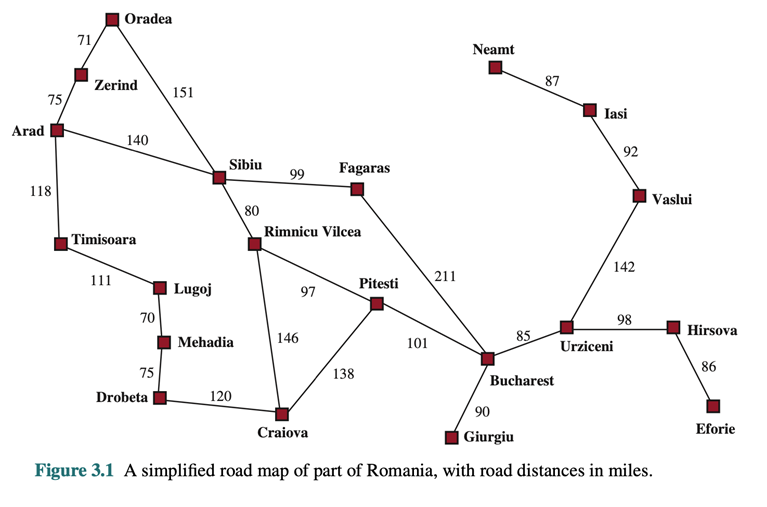

Shortest distances from Arad
Arad: 0
Zerind: 75.0
Timisoara: 118.0
Oradea: 146.0
Lugoj: 229.0
Mehadia: 299.0
Drobeta: 374.0
Sibiu: 140.0
Rimnicu V: 220.0
Craiova: 366.0
Fagaras: 239.0
Pitesti: 317.0
Bucharest: 418.0
Giurgiu: 508.0
Urziceni: 503.0
Hirsova: 601.0
Eforie: 687.0
Vaslui: 645.0
Iasi: 737.0
Neamt: 834.0


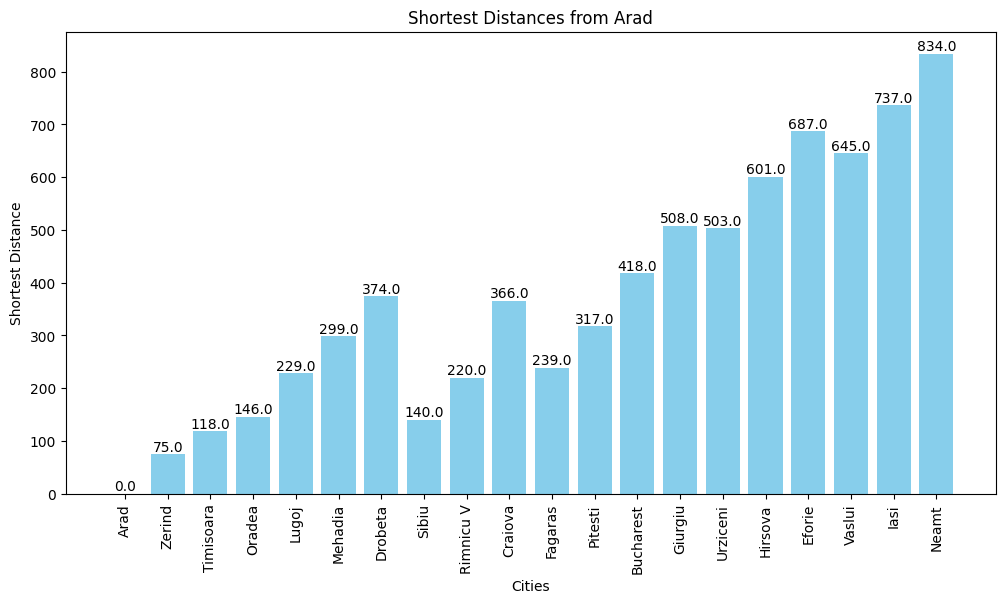

In [18]:
import numpy as np
import csv
import matplotlib.pyplot as plt

def dijkstra(adjacency_matrix, source):
    num_vertices = len(adjacency_matrix)
    dist = [float('inf')] * num_vertices
    dist[source] = 0

    visited = set()

    while len(visited) != num_vertices:
        min_dist = float('inf')
        min_index = -1
        for v in range(num_vertices):
            if v not in visited and dist[v] < min_dist:
                min_dist = dist[v]
                min_index = v

        visited.add(min_index)

        for v in range(num_vertices):
            if v not in visited and not np.isnan(adjacency_matrix[min_index][v]):
                new_dist = dist[min_index] + adjacency_matrix[min_index][v]
                if new_dist < dist[v]:
                    dist[v] = new_dist

    return dist

# Read the adjacency matrix from the CSV file
adjacency_matrix = np.genfromtxt(open("./Romania_map.csv"), delimiter=",", skip_header=1, usecols=range(1, 21))
adjacency_matrix[np.isnan(adjacency_matrix)] = np.inf

# Set the source city (e.g., Arad)
source_city = 0

# Run Dijkstra's algorithm
shortest_distances = dijkstra(adjacency_matrix, source_city)

# Print the output
cities = ['Arad', 'Zerind', 'Timisoara', 'Oradea', 'Lugoj', 'Mehadia', 'Drobeta', 'Sibiu', 'Rimnicu V', 'Craiova',
          'Fagaras', 'Pitesti', 'Bucharest', 'Giurgiu', 'Urziceni', 'Hirsova', 'Eforie', 'Vaslui', 'Iasi', 'Neamt']

print("Shortest distances from", cities[source_city])
for i, distance in enumerate(shortest_distances):
    print(cities[i] + ":", distance)

# Plot the output
plt.figure(figsize=(12, 6))
bars = plt.bar(cities, shortest_distances, color='skyblue')
plt.xlabel('Cities')
plt.ylabel('Shortest Distance')
plt.title('Shortest Distances from ' + cities[source_city])
plt.xticks(rotation=90)

# Add annotations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Show the plot
plt.show()

# Computing the all-pairs shortest paths

In [19]:
import numpy as np
import csv

def dijkstra(adjacency_matrix, source):
    num_vertices = len(adjacency_matrix)
    dist = [float('inf')] * num_vertices
    dist[source] = 0

    visited = set()

    while len(visited) != num_vertices:
        min_dist = float('inf')
        min_index = -1
        for v in range(num_vertices):
            if v not in visited and dist[v] < min_dist:
                min_dist = dist[v]
                min_index = v

        visited.add(min_index)

        for v in range(num_vertices):
            if v not in visited and not np.isnan(adjacency_matrix[min_index][v]):
                new_dist = dist[min_index] + adjacency_matrix[min_index][v]
                if new_dist < dist[v]:
                    dist[v] = new_dist

    return dist


# Read the adjacency matrix from the CSV file
adjacency_matrix = np.genfromtxt(open("./Romania_map.csv"), delimiter=",", skip_header=1, usecols=range(1, 21))
adjacency_matrix[np.isnan(adjacency_matrix)] = np.inf

# Set the source city (e.g., Arad)
source_city = 0

# Get the number of cities
num_cities = len(adjacency_matrix)

# Initialize the result matrix
result_matrix = np.zeros((num_cities, num_cities))

# Compute the all-pairs shortest paths
for source in range(num_cities):
    shortest_distances = dijkstra(adjacency_matrix, source)
    result_matrix[source] = shortest_distances

# Write the result to a CSV file
cities = ['Arad', 'Zerind', 'Timisoara', 'Oradea', 'Lugoj', 'Mehadia', 'Drobeta', 'Sibiu', 'Rimnicu V', 'Craiova',
          'Fagaras', 'Pitesti', 'Bucharest', 'Giurgiu', 'Urziceni', 'Hirsova', 'Eforie', 'Vaslui', 'Iasi', 'Neamt']

with open("all_pairs_shortest_paths.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([''] + cities)  # Write the header row
    for i, row in enumerate(result_matrix):
        writer.writerow([cities[i]] + list(row))

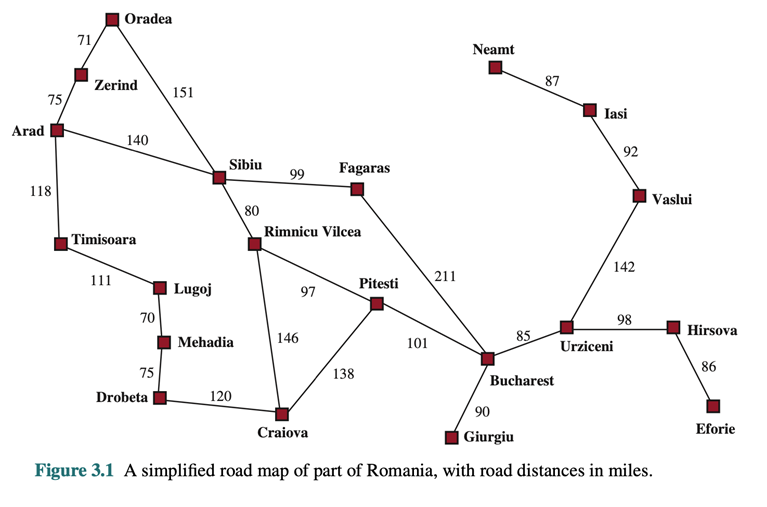

# Calculating the distance and path between 2 specific points

In [22]:
import numpy as np

def dijkstra(adjacency_matrix, source):
    num_vertices = len(adjacency_matrix)
    dist = [float('inf')] * num_vertices
    dist[source] = 0
    prev = [None] * num_vertices

    visited = set()

    while len(visited) != num_vertices:
        min_dist = float('inf')
        min_index = -1
        for v in range(num_vertices):
            if v not in visited and dist[v] < min_dist:
                min_dist = dist[v]
                min_index = v

        if min_index == -1:  # If no vertex is found, break the loop (shouldn't happen if graph is connected)
            break

        visited.add(min_index)

        for v in range(num_vertices):
            if v not in visited and not np.isnan(adjacency_matrix[min_index][v]):
                new_dist = dist[min_index] + adjacency_matrix[min_index][v]
                if new_dist < dist[v]:
                    dist[v] = new_dist
                    prev[v] = min_index

    return dist, prev

def reconstruct_path(prev, start, end):
    path = []
    while end is not None:
        path.append(end)
        end = prev[end]
    path.reverse()
    return path

# Read the adjacency matrix from the CSV file
adjacency_matrix = np.genfromtxt(open("./Romania_map.csv"), delimiter=",", skip_header=1, usecols=range(1, 21))
adjacency_matrix[np.isnan(adjacency_matrix)] = np.inf

# Define cities
cities = ['Arad', 'Zerind', 'Timisoara', 'Oradea', 'Lugoj', 'Mehadia', 'Drobeta', 'Sibiu', 'Rimnicu V', 'Craiova',
          'Fagaras', 'Pitesti', 'Bucharest', 'Giurgiu', 'Urziceni', 'Hirsova', 'Eforie', 'Vaslui', 'Iasi', 'Neamt']

# Get user input for start and end cities
start_city = input("Enter the start city: ")
end_city = input("Enter the end city: ")

# Validate city input
if start_city not in cities or end_city not in cities:
    print("Invalid city name. Please enter valid city names from the list:", cities)
else:
    start_index = cities.index(start_city)
    end_index = cities.index(end_city)

    # Run Dijkstra's algorithm
    shortest_distances, previous_vertices = dijkstra(adjacency_matrix, start_index)

    # Reconstruct the path from start to end
    path = reconstruct_path(previous_vertices, start_index, end_index)
    path_cities = [cities[i] for i in path]
    total_distance = shortest_distances[end_index]

    # Print the output
    print(f"Shortest distance from {start_city} to {end_city}: {total_distance}")
    print(f"Path: {' -> '.join(path_cities)}")

Enter the start city: Urziceni
Enter the end city: Zerind
Shortest distance from Urziceni to Zerind: 578.0
Path: Urziceni -> Bucharest -> Pitesti -> Rimnicu V -> Sibiu -> Arad -> Zerind
